In [1]:
import numpy as np
import h5py
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import ringdown as rd

from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise

from tqdm import tqdm

/work/yifan.wang/more_ringdown/env/morerd/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [2]:
fit = rd.Fit(model='mchi_aligned')
fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')

In [3]:
# stacking the posterior h_det and parameters
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
A = fit.result.posterior.A.stack(samples=('chain','draw'))
phi = fit.result.posterior.phi.stack(samples=('chain','draw'))
M = fit.result.posterior.M.stack(samples=('chain','draw'))
chi = fit.result.posterior.chi.stack(samples=('chain','draw'))

In [4]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

for s in raw_strain.values():
    fit.add_data(s)
T = 0.2
srate = 2048
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
fit.compute_acfs()

# Run Pyring

In [50]:
import sys,importlib
sys.path.append("/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/")
from pyring_par import *
import data
import wheel

In [6]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 2048, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*2048),})
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423561471921

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

# Local load data

In [68]:
importlib.reload(data)

<module 'data' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/data.py'>

In [19]:
pr_data  = {}
pr_time  = {}
for d in model.detectors.keys():
    pr_data[d],pr_time[d] = data.local_load_data(d,**test_par)


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8


# Plot data and waveform template in the same figure

In [20]:
%matplotlib inline
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'legend.frameon': True,
          'legend.loc': 'best',
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [21]:
rd_data = {}
for d in ['H1','L1']:
    rd_data[d] = fit.data[d]
    rd_data[d] = rd_data[d][(rd_data[d].index >= model.detectors['H1'].time[0]) \
                            & (rd_data[d].index <= model.detectors['H1'].time[-1])]

In [32]:
rdmfsnr = fit.compute_posterior_snrs(optimal=False)
i = np.argmax(rdmfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

In [67]:
np.max(rdmfsnr)

13.426541339972433

In [23]:
pyring_par

{'Mf': array(72.84400244),
 'af': array(0.72848178),
 'A2220': 5.595449455544791,
 'A2221': 6.457081321435618,
 'phi2220': -0.9737754582321143,
 'phi2221': 1.652119726595113}

In [98]:
importlib.reload(wheel)
#This step is for computing waveform, PyRing doesn't output a waveform
result = wheel.wheel(model)

In [99]:
wf_time, wf = result.get_hstrain(pyring_par,pr_time)

In [100]:
crop_time, crop_data = result.get_data(pr_time,pr_data)

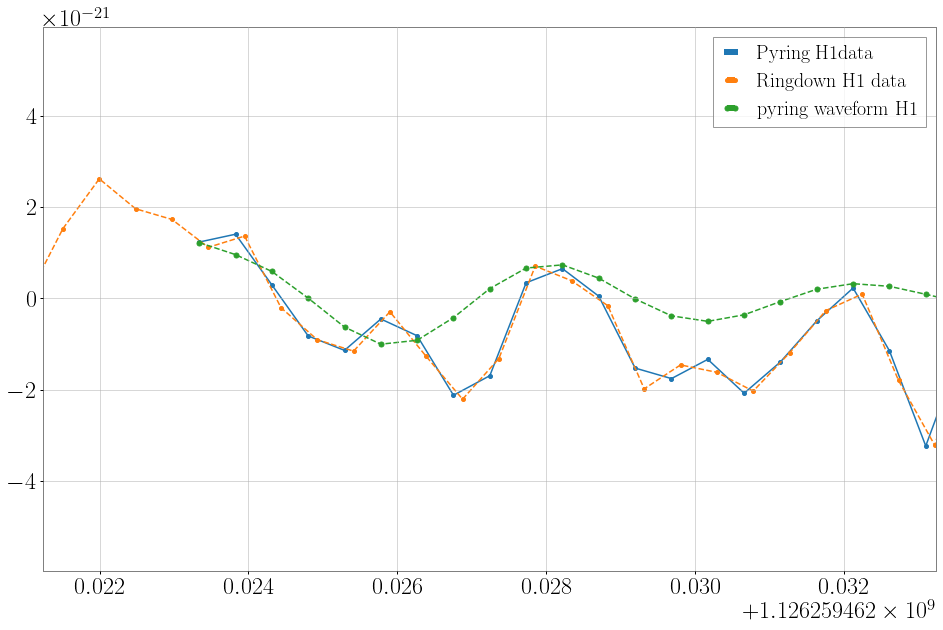

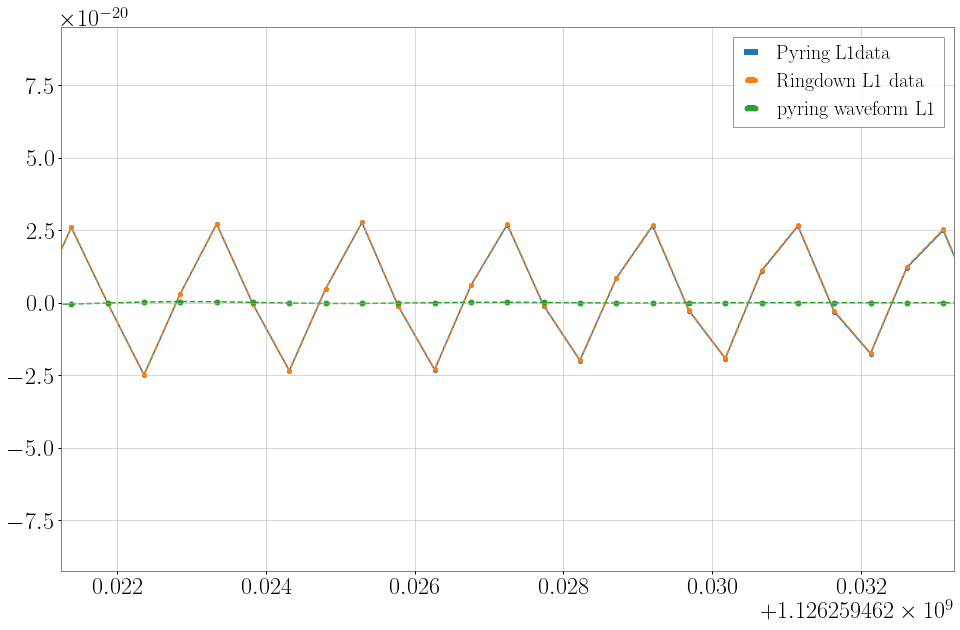

In [101]:
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(crop_time[d],crop_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+' data')

    #plot waveform   
    plt.plot(wf_time[d],wf[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    #plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='Ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

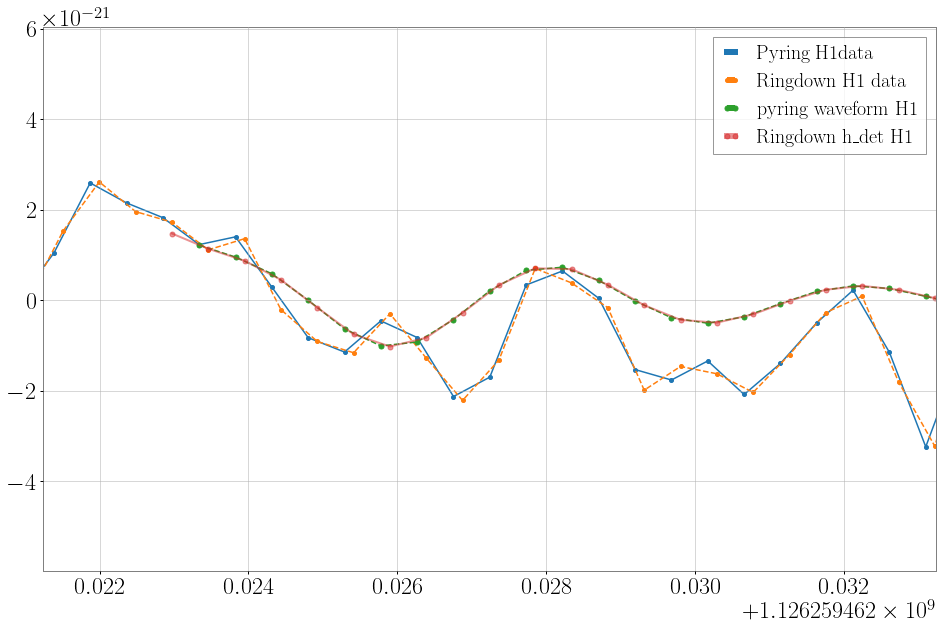

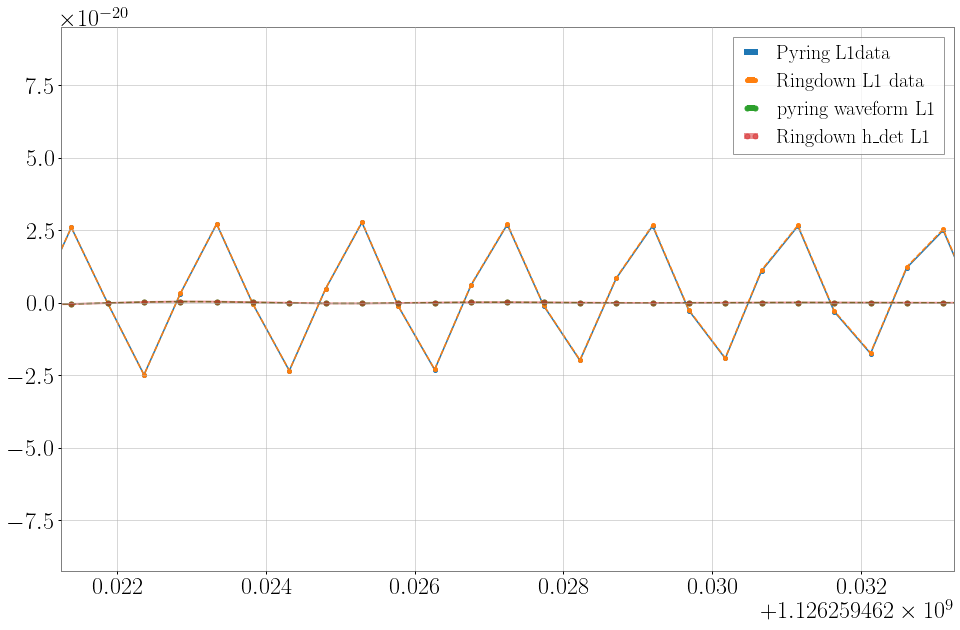

In [102]:
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(pr_time[d],pr_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+' data')

    #plot waveform   
    plt.plot(wf_time[d],wf[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='Ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

In [103]:
fit.analysis_data['H1'].index[0]

1126259462.4229736

In [104]:
wf_time['H1'][0]

1126259462.4233398

In [105]:
np.sqrt(2 * (model.log_likelihood(pyring_par) - model.logZnoise))

12.522362315152748

# Matched-filter and Optimal SNR comparison

In [106]:
prmf = result.mfsnr(pyring_par,pr_time,pr_data,network=True)
propt = result.optsnr(pyring_par,pr_time,network=True)

In [107]:
prmf,propt

(13.573830690387627, 12.789947764796873)

In [108]:
pr_optsnr_net,pr_mfsnr_net = wheel.compute_multiple_snr(
    model,pr_time,pr_data,M,chi,A,phi,network=True,acf_from_psd=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:46<00:00, 37.62it/s]


In [109]:
rd_optsnr = fit.compute_posterior_snrs(optimal=True,network=True)
rd_mfsnr = fit.compute_posterior_snrs(optimal=False,network=True)
rd_optsnr_nonet = fit.compute_posterior_snrs(optimal=True,network=False)
rd_mfsnr_nonet = fit.compute_posterior_snrs(optimal=False,network=False)

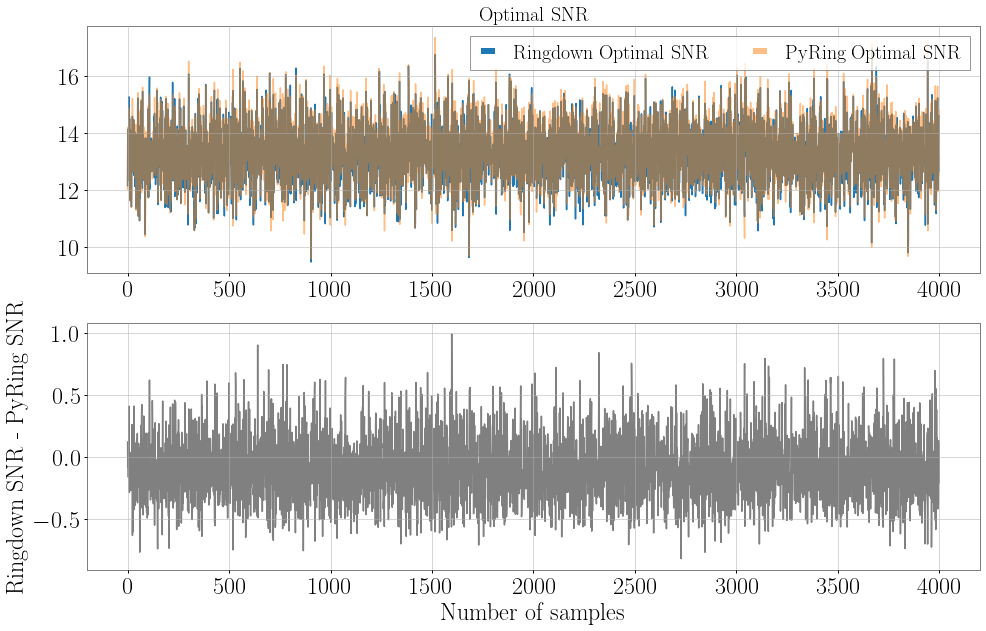

In [110]:
wheel.plotsnr(rd_optsnr,pr_optsnr_net,snr='Optimal SNR')

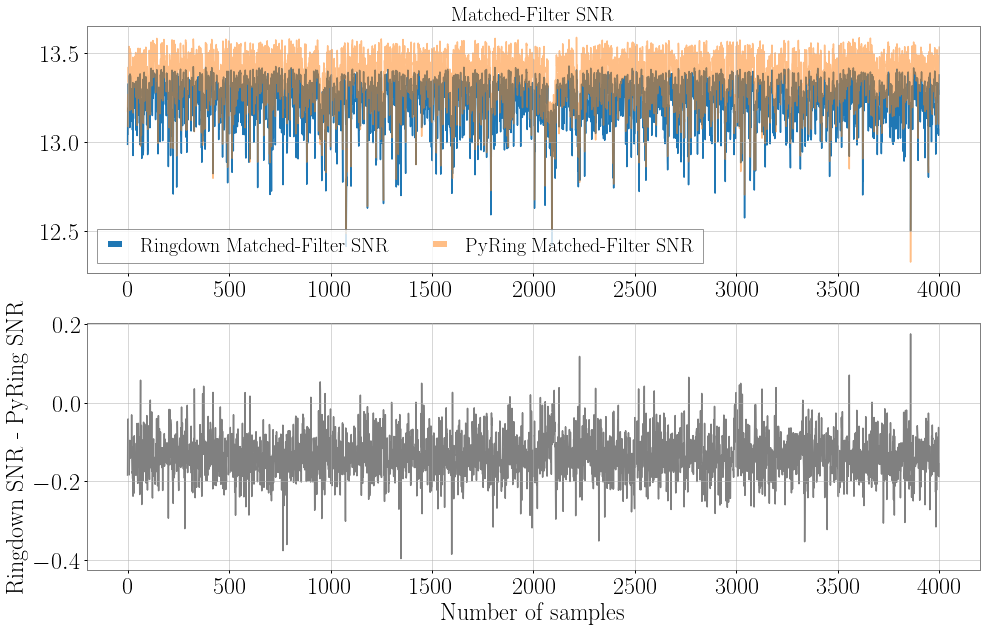

In [111]:
wheel.plotsnr(rd_mfsnr,pr_mfsnr_net,snr='Matched-Filter SNR')

# Matched-filter and Optimal SNR from ringdown ACF

In [169]:
importlib.reload(wheel)

<module 'wheel' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/wheel.py'>

In [129]:
pr_optsnr_netafr,pr_mfsnr_netafr = wheel.compute_multiple_snr(
    model,pr_time,pr_data,M,chi,A,phi,fit=fit,network=True,acf_from_psd=False,acf_from_ringdown=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:39<00:00, 40.17it/s]


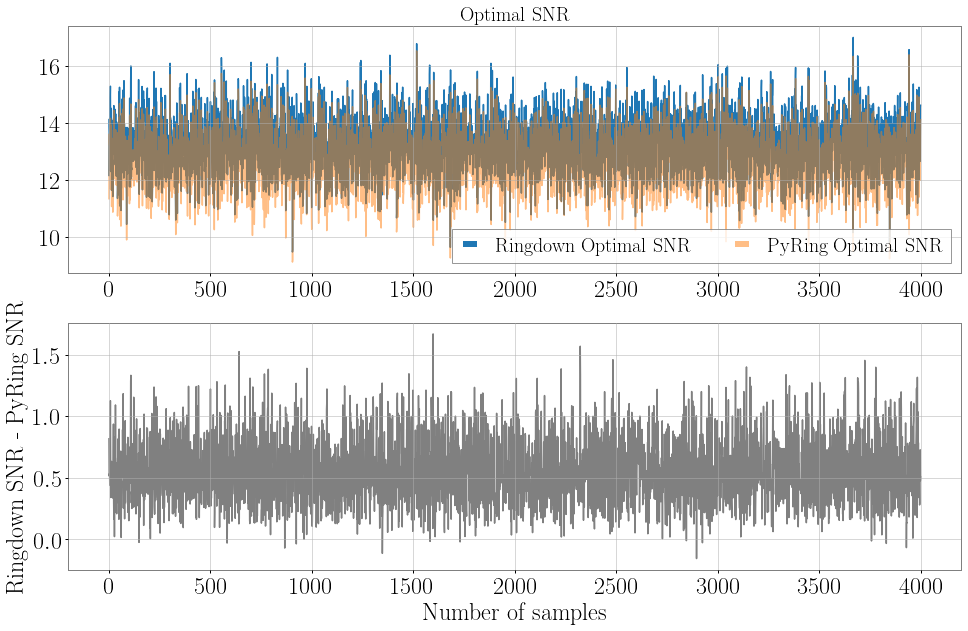

In [130]:
wheel.plotsnr(rd_optsnr,pr_optsnr_netafr,snr='Optimal SNR')

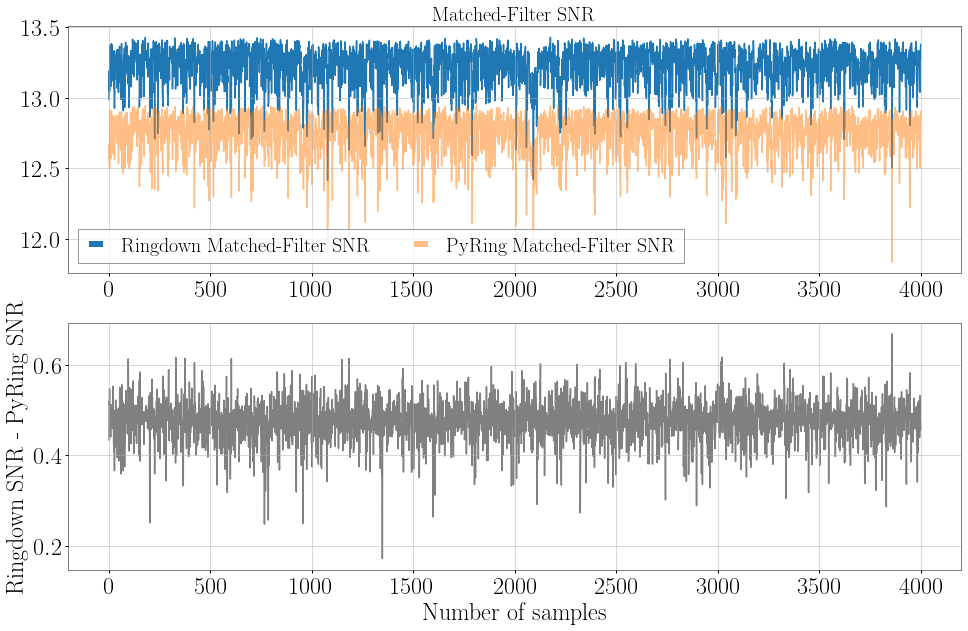

In [131]:
wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafr,snr='Matched-Filter SNR')

# Impact of duration on SNR

In [174]:
test_par0p1 = input_par
test_par0p1.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 2048, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*2048),})
model0p1 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par0p1)
pr_data0p1  = {}
pr_time0p1  = {}
for d in model0p1.detectors.keys():
    pr_data0p1[d],pr_time0p1[d] = data.local_load_data(d,**test_par0p1)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423561471921

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

In [175]:
pr_optsnr_net0p1,pr_mfsnr_net0p1 = wheel.compute_multiple_snr(
    model0p1,pr_time0p1,pr_data0p1,M,chi,A,phi,network=True,acf_from_psd=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:29<00:00, 44.46it/s]


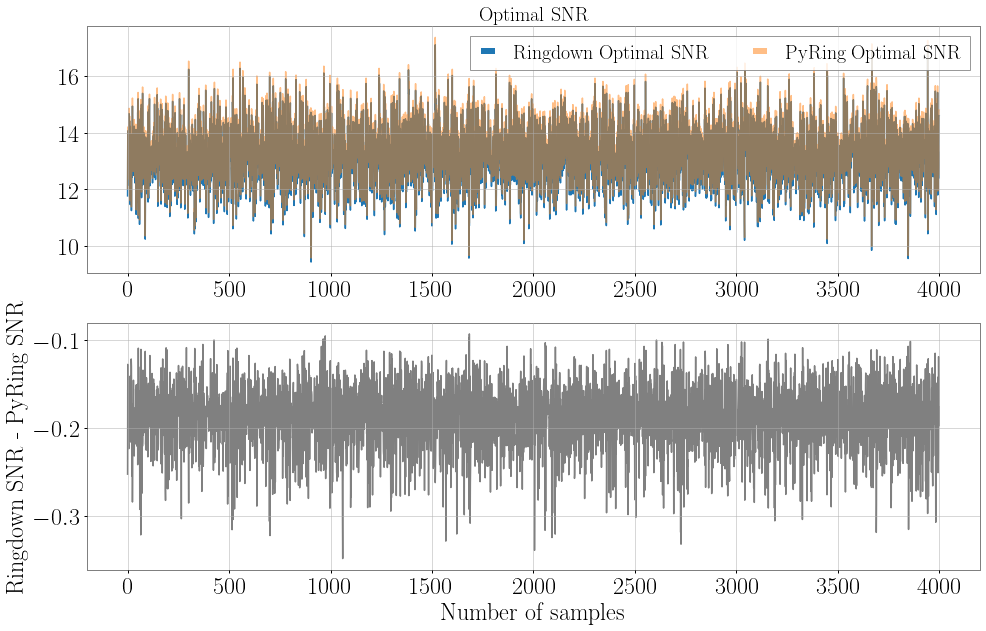

In [177]:
wheel.plotsnr(np.array(pr_optsnr_net0p1),np.array(pr_optsnr_net),snr='Optimal SNR')

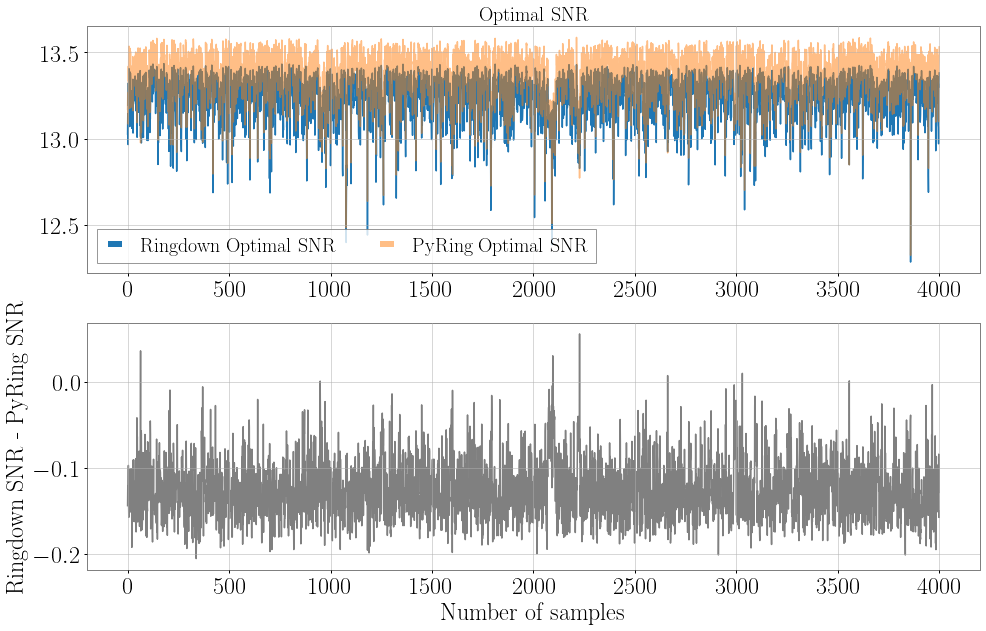

In [178]:
wheel.plotsnr(np.array(pr_mfsnr_net0p1),np.array(pr_mfsnr_net),snr='Optimal SNR')

# Rank the posteriors according to log posterior

In [137]:
lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))
lparg = np.argsort(lp.values)

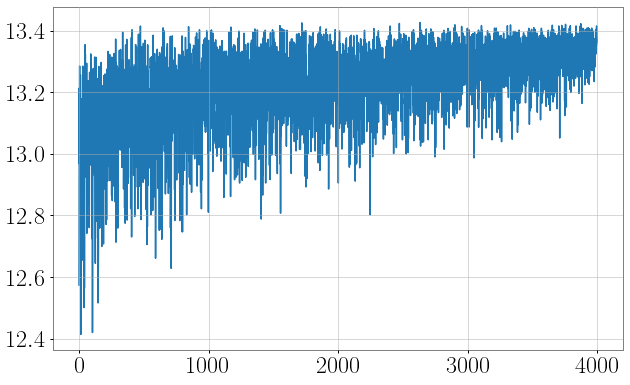

In [141]:
plt.plot(rd_mfsnr[lparg])

In [146]:
pyringloglr = []
for i in tqdm(lparg):
    prefactor = np.sqrt(16*np.pi/5)
    pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    pyringloglr.append(model.log_likelihood(pyring_par))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:45<00:00, 88.84it/s]


In [147]:
snr = np.sqrt( 2 * (np.array(pyringloglr) - model.logZnoise))

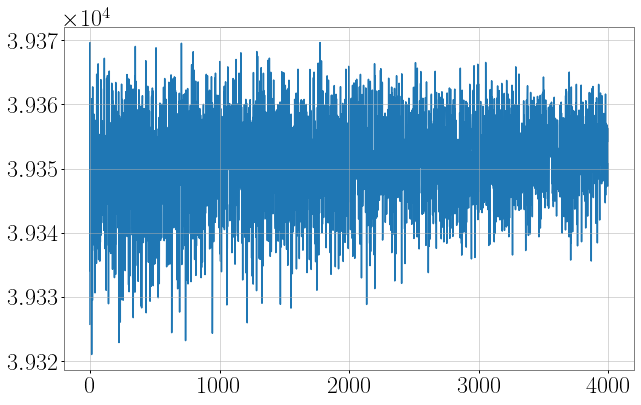

In [148]:
plt.plot(pyringloglr)

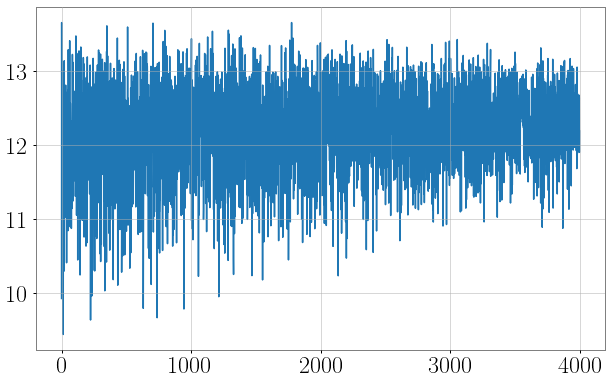

In [149]:
plt.plot(snr)

In [152]:
lparg

array([3040, 1789, 1708, ..., 1564,  439, 1465])

In [153]:
fit.draw_sample(map=True)

(1465,
 Data variables:
     log_drift_unit  (log_drift_unit_dim_0) float64 0.3642 -0.07093
     M               float64 73.17
     chi             float64 0.7367
     cosi            float64 -0.9939
     iota_unit       (iota_unit_dim_0) float64 -0.3248 0.9458
     Ax_unit         (Ax_unit_dim_0) float64 0.2065 0.006218
     Ay_unit         (Ay_unit_dim_0) float64 0.2841 -0.3736
     dts             (dts_dim_0) float64 -5.079e-07
     df              (df_dim_0) float64 0.2558 0.0445
     dtau            (dtau_dim_0) float64 -0.1428 0.1151
     drift           (drift_dim_0) float64 1.0 1.0
     gamma           (gamma_dim_0) float64 219.8 664.0
     f               (f_dim_0) float64 242.9 238.4
     h_det_mode      (h_det_mode_dim_0, h_det_mode_dim_1, h_det_mode_dim_2) float64 ...
     h_det           (h_det_dim_0, h_det_dim_1) float64 1.635e-21 ... 5.686e-41
     A               (A_dim_0) float64 1.756e-21 1.868e-21
     phi             (phi_dim_0) float64 0.9423 -1.554
     tau       

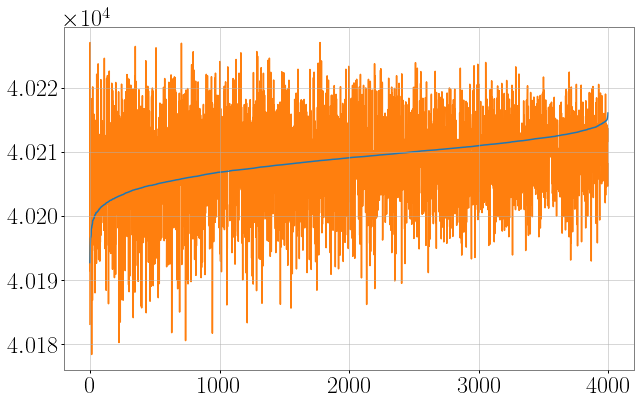

In [159]:
plt.plot(lp[lparg])
plt.plot(np.array(pyringloglr)+(np.median(lp)-np.median(pyringloglr)),zorder=-1)
#plt.plot(np.array(pyringloglr) - model.logZnoise)

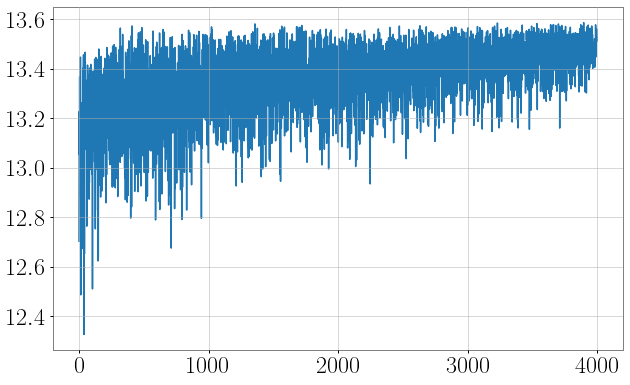

In [164]:
plt.plot(np.array(pr_mfsnr_net)[lparg])

In [179]:
mfsnrarg = np.argsort(rd_mfsnr)

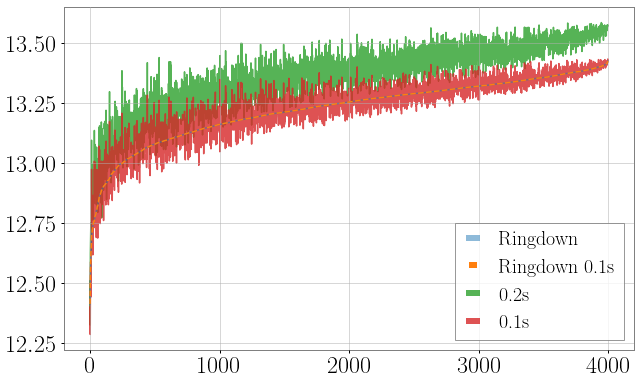

In [192]:
plt.plot(rd_mfsnr[mfsnrarg],label='Ringdown',alpha=0.5,zorder=9)
plt.plot(rd_mfsnr_0p1[mfsnrarg],label='Ringdown 0.1s',ls='--',zorder=9)
plt.plot(np.array(pr_mfsnr_net)[mfsnrarg],alpha=0.8,label='0.2s')
plt.plot(np.array(pr_mfsnr_net0p1)[mfsnrarg],alpha=0.8,label='0.1s')
plt.legend()

In [187]:
fit0p1 = rd.Fit(model='mchi_aligned')
#fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
for s in raw_strain.values():
    fit0p1.add_data(s)
T = 0.1
srate = 2048
fit0p1.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit0p1.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
fit0p1.compute_acfs()

In [188]:
fit0p1.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
rd_mfsnr_0p1 = fit0p1.compute_posterior_snrs(optimal=False,network=True)

In [ ]:
pr_optsnr_netafp,pr_mfsnr_netafp = wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=True,acf_from_psd=True)

In [ ]:
pr_optsnr_nonet, pr_mfsnr_nonet = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=False)

In [ ]:
pyring_wheel.plotsnr(rd_optsnr,pr_optsnr_netafp,snr='Optimal SNR')

In [ ]:
pyring_wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafp,snr='Matched-Filter SNR')

# Plot H1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[0],pr_optsnr_nonet['H1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[0],pr_mfsnr_nonet['H1'],snr='Matched-Filter SNR')

# Plot L1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[1],pr_optsnr_nonet['L1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[1],pr_mfsnr_nonet['L1'],snr='Matched-Filter SNR')

In [ ]:
model.time_delay

# Compute MF SNR for a single sample but with different srate and duration and data conditioning

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model1 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model2 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':512,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model3 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 16384, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*16384)})
model4 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*4096)})
model5 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.4, 
                'analysis-duration-n': int(0.4*4096)})
model6 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr1 = pyring_wheel(model1)
pr1.mfsnr(pyring_par)

In [ ]:
pr2 = pyring_wheel(model2)
pr2.mfsnr(pyring_par)

In [ ]:
pr3 = pyring_wheel(model3)
pr3.mfsnr(pyring_par)

In [ ]:
pr4 = pyring_wheel(model4)
pr4.mfsnr(pyring_par)

In [ ]:
pr5 = pyring_wheel(model5)
pr5.mfsnr(pyring_par)

In [ ]:
pr6 = pyring_wheel(model6)
pr6.mfsnr(pyring_par)

# How about 8192 Hz

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 8192, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*8192)})
model11 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr11 = pyring_wheel(model11)
pr11.mfsnr(pyring_par)

In [ ]:
pyring_par

# Plot the waveforms

In [ ]:
for i in range(1):
    prefactor = np.sqrt(16*np.pi/5)
    pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    
    result = pyring_wheel(model,pyring_par)
    plt.figure(figsize=[16,10])
    
    plt.plot(model.tevent+time_array['H1']+dt['H1'],result.hstrain['H1'],ls='--',marker='o',ms=5,label='pyring H1')
    plt.plot(fit.analysis_data['H1'].index,hs[0,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det H1')
    
    plt.plot(model.tevent+time_array['L1']+dt['L1'],result.hstrain['L1'],ls='--',marker='o',ms=5,label='pyring L1')
    plt.plot(fit.analysis_data['L1'].index,hs[1,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det L1')
    
    plt.xlim(fit.analysis_data['H1'].index[0]-0.02,fit.analysis_data['H1'].index[0]+0.05)
    plt.legend(loc='best')

In [ ]:
fit.analysis_data['H1'].index[0]

# Evidence that maybe the data conditioning make the difference here

PyRing data conditioning: 

Band pass: [20,1014] Hz

sampling rate: 2048 Hz

In [ ]:
fit.analysis_data

In [ ]:
plt.hist(A[1][:].values*prefactor/1e-21,bins=np.linspace(0,50,100),density=True)
plt.axhline(0.02,ls='--')